In [17]:
crimes <- read.csv("../data/crimes.csv")
crimes$region_central <- crimes$region == "central"
crimes$region_west <- crimes$region == "west"
# crimes$region_other <- crimes$region == "other"

crimes$region_central <- as.integer(as.logical(crimes$region_central))
crimes$region_west <- as.integer(as.logical(crimes$region_west))
# crimes$region_other <- as.integer(as.logical(crimes$region_other))

crimes <- subset(crimes, select = -c(region, name))
crimes$crimes <- round(log(crimes$crimes))
head(crimes)

,crimes,prbarr,prbpris,polpc,density,area,taxpc,pctmin,pctymale,wcon,wsta,wser,wtrd,wfir,region_central,region_west
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,8,0.289696,0.472222,0.0017868,230.71590,423.943,25.69763,20.21870,0.0876968,206.4803,236.24,215.7335,182.3330,272.4492,1,0
2,6,0.202899,0.465753,0.0005939,97.68340,259.994,14.56088,7.91632,0.0870046,188.7683,247.38,191.3742,151.4234,202.4292,1,0
3,5,0.406593,0.500000,0.0008209,41.27659,235.059,18.63060,3.16053,0.0738525,147.9290,233.33,158.2278,143.5132,200.3205,0,1
4,6,0.431095,0.431373,0.0014327,48.21764,531.452,38.24473,47.91610,0.0836378,284.5809,206.07,208.4636,174.2457,207.1006,1,0
5,5,0.631579,0.383333,0.0008353,53.05164,426.135,16.85321,1.79619,0.0790580,195.9361,234.75,178.7785,152.7354,209.0301,0,1
6,6,0.369650,0.226415,0.0019067,59.10931,247.087,22.32144,1.54070,0.1063334,199.2377,227.69,176.5392,150.5835,195.3125,0,1


In [18]:
# install.packages("dplyr")
require(dplyr)

rnd_design_matrix <- function(original_data, num_rows) {
    des_mx <- data.frame(original_data) # copy the data frame
    des_mx <- des_mx[0,] # delete all rows
    
    for (i in 1 : num_rows) {
        # Add the row
        des_mx <- rbind(des_mx, sample_n(original_data, 1))
    }
    
    return(des_mx)
}

add_to_design_matrix <- function(curr_design_matrix, original_data, num_rows){
    des_mx <- data.frame(curr_design_matrix) # copy the data frame
    
    for (i in 1 : num_rows) {
        # Add the row
        des_mx <- rbind(des_mx, sample_n(original_data, 1))
    }
    
    return(des_mx)
}

In [19]:
des_mtr <- rnd_design_matrix(crimes, 10)
des_mtr

crimes,prbarr,prbpris,polpc,density,area,taxpc,pctmin,pctymale,wcon,wsta,wser,wtrd,wfir,region_central,region_west
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
7,0.321212,0.414414,0.0008694,81.92220,440.608,18.53749,5.52725,0.0762992,183.5143,255.67,173.9060,159.9843,231.1896,0,1
8,0.270776,0.432558,0.0011919,102.42510,708.958,21.03440,29.90720,0.1394802,234.0786,195.81,231.3200,173.2183,237.4169,0,0
8,0.205165,0.413420,0.0013775,208.75910,552.675,19.24220,10.99570,0.0855260,228.1871,206.78,204.6954,179.6187,230.1752,1,0
7,0.153444,0.517949,0.0013737,110.94620,532.166,19.58383,5.64349,0.0834044,267.1756,219.13,195.9060,171.0741,235.5506,0,1
6,0.306954,0.440000,0.0015162,63.22751,378.528,25.38036,6.03408,0.0951802,190.4037,239.51,181.1893,139.6460,208.8409,0,1
7,0.319665,0.500000,0.0012070,49.75787,827.192,20.10284,32.17940,0.0793392,192.6931,247.95,182.9082,172.9289,230.1118,0,0
8,0.270776,0.432558,0.0011919,102.42510,708.958,21.03440,29.90720,0.1394802,234.0786,195.81,231.3200,173.2183,237.4169,0,0
5,0.631579,0.383333,0.0008353,53.05164,426.135,16.85321,1.79619,0.0790580,195.9361,234.75,178.7785,152.7354,209.0301,0,1
8,0.582504,0.522634,0.0007317,125.74070,540.407,19.22906,34.27990,0.0851622,219.6220,250.21,212.9582,193.1002,328.2547,0,0


In [20]:
des_mtr <- add_to_design_matrix(des_mtr, crimes, 10)
des_mtr

crimes,prbarr,prbpris,polpc,density,area,taxpc,pctmin,pctymale,wcon,wsta,wser,wtrd,wfir,region_central,region_west
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
7,0.321212,0.414414,0.0008694,81.92220,440.608,18.53749,5.52725,0.0762992,183.5143,255.67,173.9060,159.9843,231.1896,0,1
8,0.270776,0.432558,0.0011919,102.42510,708.958,21.03440,29.90720,0.1394802,234.0786,195.81,231.3200,173.2183,237.4169,0,0
8,0.205165,0.413420,0.0013775,208.75910,552.675,19.24220,10.99570,0.0855260,228.1871,206.78,204.6954,179.6187,230.1752,1,0
7,0.153444,0.517949,0.0013737,110.94620,532.166,19.58383,5.64349,0.0834044,267.1756,219.13,195.9060,171.0741,235.5506,0,1
6,0.306954,0.440000,0.0015162,63.22751,378.528,25.38036,6.03408,0.0951802,190.4037,239.51,181.1893,139.6460,208.8409,0,1
7,0.319665,0.500000,0.0012070,49.75787,827.192,20.10284,32.17940,0.0793392,192.6931,247.95,182.9082,172.9289,230.1118,0,0
8,0.270776,0.432558,0.0011919,102.42510,708.958,21.03440,29.90720,0.1394802,234.0786,195.81,231.3200,173.2183,237.4169,0,0
5,0.631579,0.383333,0.0008353,53.05164,426.135,16.85321,1.79619,0.0790580,195.9361,234.75,178.7785,152.7354,209.0301,0,1
8,0.582504,0.522634,0.0007317,125.74070,540.407,19.22906,34.27990,0.0851622,219.6220,250.21,212.9582,193.1002,328.2547,0,0


In [21]:
likelihood_confidence <- function(model, alpha){
    df <- as.data.frame(matrix(ncol = 2))
    colnames(df) <- c("2.5%", "97.5%")
    df <- df[0,]
    
    bound = 1 - alpha/2
    
    row_names <- c()
    
    for (i in 1:length(coef(model))){
        l_bound = coef(model)[i] - qnorm(bound) * sqrt(vcov(model)[i,i])
        u_bound = coef(model)[i] + qnorm(bound) * sqrt(vcov(model)[i,i])
        
        name = names(coef(model)[i])
        row_names <- append(row_names, name)
        
        df[nrow(df) + 1,] = c(l_bound,u_bound)
    }
    rownames(df) <- row_names
    return(df)
}

In [22]:
model = glm(crimes ~ 1+prbarr+prbpris+polpc+density+area+taxpc+region_central+region_west+pctmin+pctymale+wcon+wsta+wser+wtrd+wfir, data=crimes, family=poisson(link="log"))

# R Profile-Likelihood-Confidence Interval
r_conf <- confint(model)
# Own Likelihood-Confidence Intervall
my_conf <- likelihood_confidence(model, 0.05)

r_conf
my_conf

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),1.203520e-01,2.786869095
prbarr,-1.050336e+00,0.443780021
prbpris,-7.093033e-01,1.494875785
polpc,-7.845996e+01,48.152937028
density,-1.785680e-04,0.001423604
area,-2.317497e-04,0.000660978
taxpc,-1.328425e-02,0.011608856
region_central,-2.075617e-01,0.248016583
region_west,-3.547893e-01,0.295009215
pctmin,-7.270932e-03,0.007815839


,2.5%,97.5%
,<dbl>,<dbl>
(Intercept),1.163329e-01,2.782039760
prbarr,-1.042851e+00,0.450563571
prbpris,-7.131683e-01,1.490527170
polpc,-7.527264e+01,50.804510424
density,-1.657875e-04,0.001434788
area,-2.316497e-04,0.000660530
taxpc,-1.297932e-02,0.011889233
region_central,-2.078861e-01,0.247521614
region_west,-3.547079e-01,0.294769349


In [23]:
eval_coefficients <- function(coe, r_conf, my_conf){
    r_conf_hits = rep(0, length.out=nrow(coe))
    my_conf_hits = rep(0, length.out=nrow(coe))
    
    for (i in 1:ncol(coe)){
        for (j in 1:nrow(coe)){
            if ((coe[j, i] > r_conf[j, 1]) && (coe[j,i] < r_conf[j, 2])){
                r_conf_hits[j] <- r_conf_hits[j] + 1
            }
            if ((coe[j, i] > my_conf[j, 1]) && (coe[j,i] < my_conf[j, 2])){
                my_conf_hits[j] <- my_conf_hits[j] + 1
            }
        }
    }
    
    r_conf_hits <- r_conf_hits/ncol(coe)
    my_conf_hits <- my_conf_hits/ncol(coe)
    
    return(list(r_conf_hits, my_conf_hits))
}

In [24]:
gen_coef <- function(design_matrix, mu){
    ### Simulation von Pseudo-Beobachtungen
    n = nrow(design_matrix)
    y.sim = rpois(n, mu)
    
    ### Schätzung der Parameter
    m = glm(y.sim~1+prbarr+prbpris+polpc+density+area+taxpc+region_central+region_west+pctmin+pctymale+wcon+wsta+wser+wtrd+wfir, data=design_matrix, family=poisson(link="log"))
    
    lh_intervalls = likelihood_intervalls(m, 0.05)
    
    return(coe)
}

get_intervals <- function(design_matrix, mu){
    ### Simulation von Pseudo-Beobachtungen
    n = nrow(design_matrix)
    y.sim = rpois(n, mu)
    
    ### Schätzung der Parameter
    m = glm(y.sim~1+prbarr+prbpris, data=design_matrix, family=poisson(link="log"))
    
    my_conf = likelihood_confidence(m, 0.05)
    r_conf = suppressMessages(confint(m))
    
    return(list(my_conf, r_conf))
}

get_m_intervals <- function(m, design_matrix, mu){
    intervals = get_intervals(design_matrix, mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    
    my_m_intervals = data.frame(my_conf)
    r_m_intervals = data.frame(r_conf)
    
    for (i in 1:(m-1)){
        intervals = get_intervals(design_matrix, mu)
        my_conf = intervals[[1]]
        r_conf = intervals[[2]]
        
        my_m_intervals = cbind(my_m_intervals, my_conf)
        r_m_intervals = cbind(r_m_intervals, r_conf)
    }
    
    return(list(my_m_intervals, r_m_intervals))
}

eval_coefficients <- function(coe, r_conf, my_conf){
    r_conf_hits = rep(0, length.out=nrow(coe))
    my_conf_hits = rep(0, length.out=nrow(coe))
       
    for (i in 1:ncol(coe)){
        for (j in 1:nrow(coe)){
            if ((coe[j, i] > r_conf[j, 1]) && (coe[j,i] < r_conf[j, 2])){
                r_conf_hits[j] = r_conf_hits[j] + 1
            }
            if ((coe[j, i] > my_conf[j, 1]) && (coe[j,i] < my_conf[j, 2])){
                my_conf_hits[j] = my_conf_hits[j] + 1
            }
        }
    }
    
    r_conf_hits = r_conf_hits/ncol(coe)
    my_conf_hits = my_conf_hits/ncol(coe)
    
    return(list(r_conf_hits, my_conf_hits))
}

eval_m_intervals <- function(true_coef, my_m_intervals, r_m_intervals){
    num_coef = nrow(true_coef)
    m = ncol(my_m_intervals)/2
    
    r_conf_hits = my_conf_hits = rep(0, length.out=num_coef)
    
    for (j in 1:m){
        l_bound = my_m_intervals[ , j*2 - 1]
        u_bound = my_m_intervals[ , j*2]       
        for (i in 1:num_coef){
            coe = true_coef[i,1]           
            if (coe > l_bound[i] && coe < u_bound[i]){
                my_conf_hits[i] = my_conf_hits[i] + 1
            }
        }
        
        l_bound = r_m_intervals[ , j*2 - 1]
        u_bound = r_m_intervals[ , j*2]
        for (i in 1:num_coef){
            coe = true_coef[i,1]
            if (coe > l_bound[i] && coe < u_bound[i]){
                r_conf_hits[i] = r_conf_hits[i] + 1
            }
        }
    }
    
    r_conf_hits = r_conf_hits / m
    my_conf_hits = my_conf_hits / m
    
    return(list(my_conf_hits, r_conf_hits))
}

In [25]:
experiment = function(data, true_model, model, n_start, increase, num_times, m){
    true_mu = predict(true_model, type="response")
    true_coef = data.frame(coefficients=coef(true_model))
    
    # first iteration
    des_matrix = rnd_design_matrix(crimes, n_start)
    intervals = get_m_intervals(m, des_matrix, true_mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    hits = eval_m_intervals(true_coef, r_conf, my_conf)
    
    r_res = data.frame(n_start = hits[[1]])
    my_res = data.frame(n_start = hits[[2]])
    
    rownames(r_res) = names(coef(true_model))
    rownames(my_res) = names(coef(true_model))
    
    colnames(r_res) = c(n_start)
    colnames(my_res) = c(n_start)
    
    
    for (n in 1:num_times-1){
        des_matrix = add_to_design_matrix(des_matrix, crimes, increase)
        intervals = get_m_intervals(m, des_matrix, true_mu)
        my_conf = intervals[[1]]
        r_conf = intervals[[2]]
        hits = eval_m_intervals(true_coef, r_conf, my_conf)
        
        temp_r_res = data.frame(x = hits[[1]])
        temp_my_res = data.frame(x = hits[[2]])
        
        colnames(temp_r_res) = c(nrow(des_matrix))
        colnames(temp_my_res) = c(nrow(des_matrix))
        
        # colnames(temp_res) = c(paste(as.character(n_start + n*increase)," r_hits"), paste(as.character(n_start + n*increase)," my_hits"))
        
        r_res = cbind(r_res, temp_r_res)
        my_res = cbind(my_res, temp_my_res)
    }
    
    return(list(r_res, my_res))
}

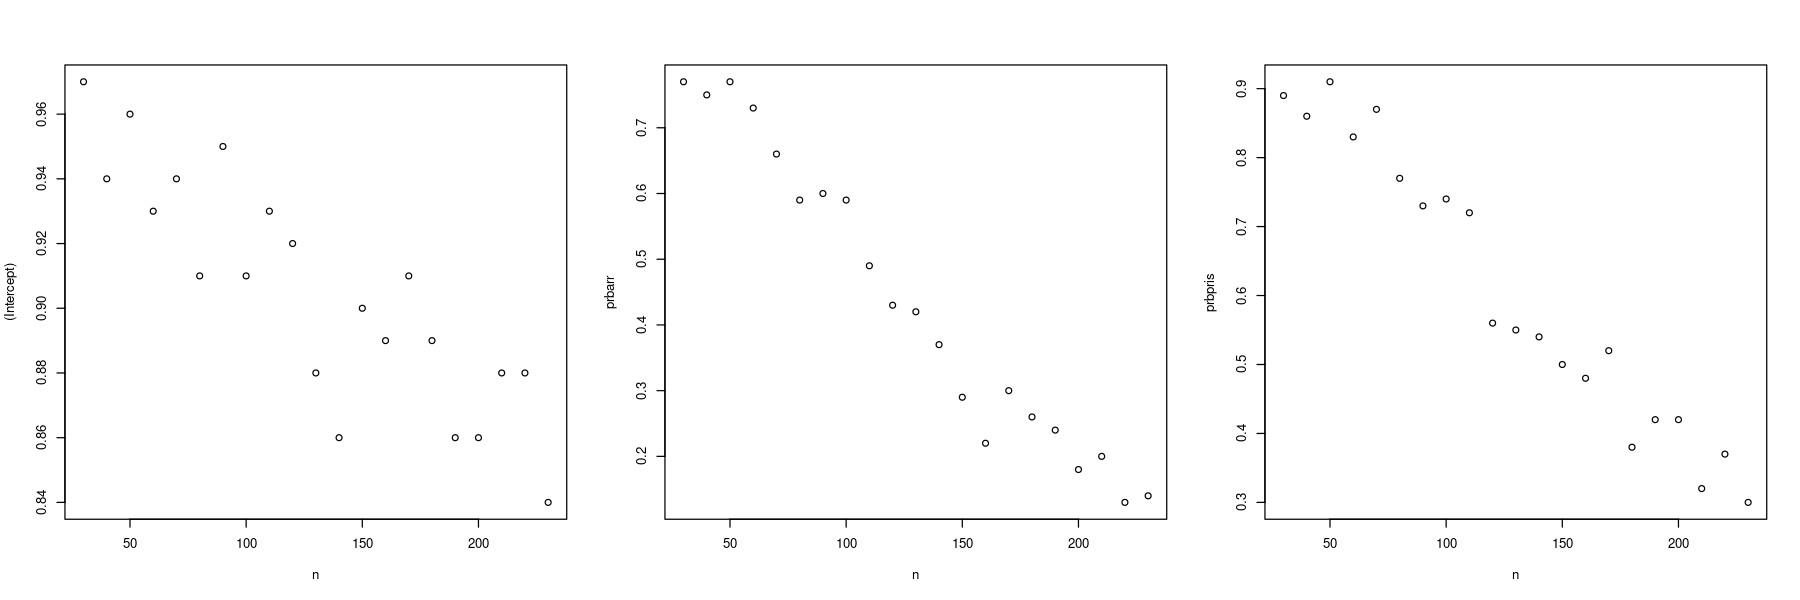

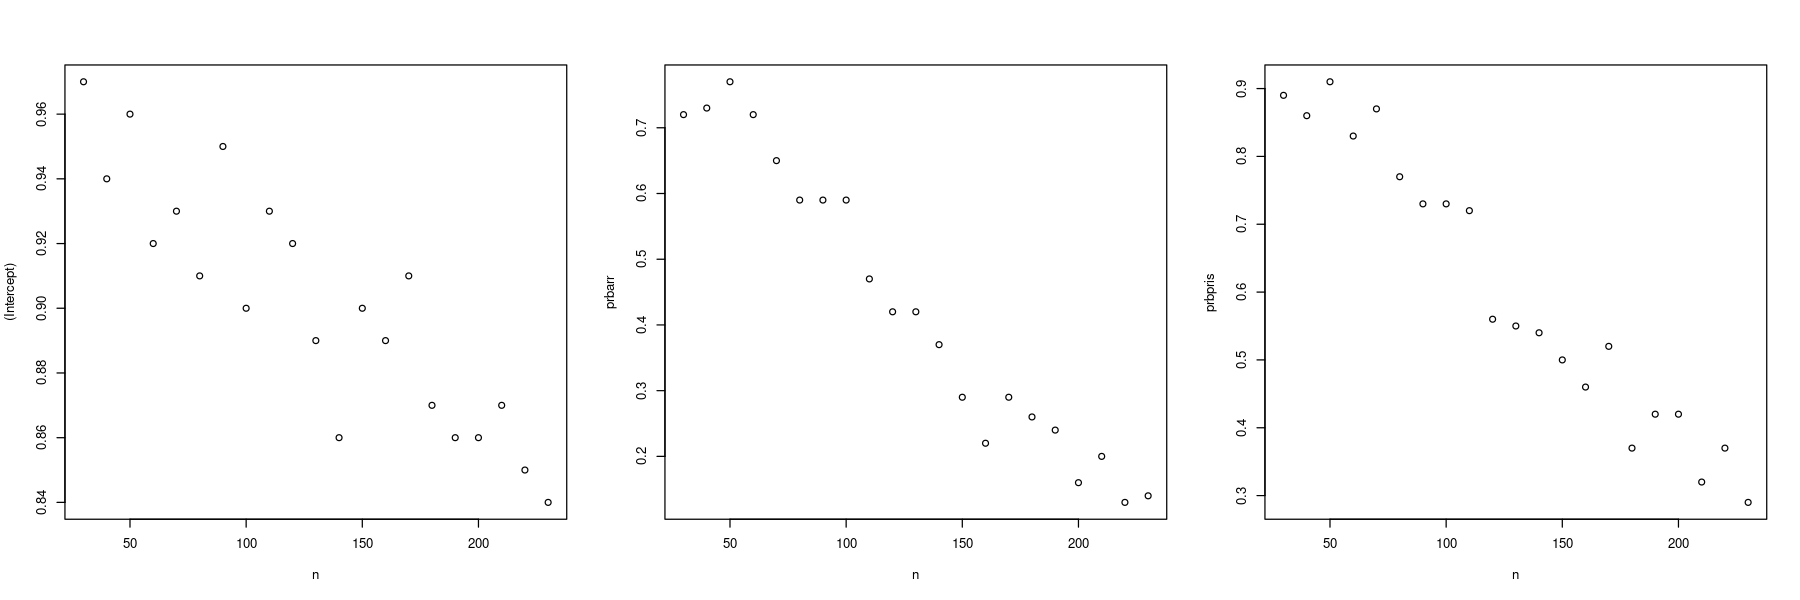

In [27]:

true_model = glm(crimes ~ 1+prbarr+prbpris, data=crimes, family=poisson(link="log"))

res = experiment(crimes, true_model, model, 30, 10, 20, 100)
r_res = res[[1]]
my_res = res[[2]]

r_res = rbind(as.numeric(colnames(r_res)), r_res)
my_res = rbind(as.numeric(colnames(my_res)), my_res)

r_res = t(r_res)
my_res = t(my_res)

options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(r_res[, 1], r_res[, 2], xlab="n", ylab="(Intercept)")
plot(r_res[, 1], r_res[, 3], xlab="n", ylab="prbarr")
plot(r_res[, 1], r_res[, 4], xlab="n", ylab="prbpris")

plot(my_res[, 1], my_res[, 2], xlab="n", ylab="(Intercept)")
plot(my_res[, 1], my_res[, 3], xlab="n", ylab="prbarr")
plot(my_res[, 1], my_res[, 4], xlab="n", ylab="prbpris")